## Portfolio Simulation
In this notebook, I will save predictions of all tickers and use them to simulate equal weight portfolio.

In [1]:
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

In [2]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Load training data
data = pd.read_csv("data/modeling/AAPL_model_data.csv", index_col="Date", parse_dates=True)
X = data.drop(columns=["Target"])
y = data["Target"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Train model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

/Users/tan/miniconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:31:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [3]:
import joblib

os.makedirs("models", exist_ok=True)

joblib.dump(xgb, "../models/xgb_model.pkl")

['../models/xgb_model.pkl']

In [4]:
import pandas as pd
import os

tickers = ["AAPL", "NVDA", "VOO", "JPM", "GLD", "BTC-USD", "PFE"]

os.makedirs("../data/modeling", exist_ok=True)

for ticker in tickers:
    # Load features
    features = pd.read_csv(f"data/features/{ticker}_features.csv", index_col="Date", parse_dates=True)
    
    # Load log returns
    returns = pd.read_csv(f"data/processed/{ticker}_log_returns.csv", index_col="Date", parse_dates=True)
    
    # Create target: 1 if next day's return > 0, else 0
    target = (returns.shift(-1) > 0).astype(int)
    target.columns = ["Target"]

    # Align features and target
    df = features.join(target, how="inner").dropna()

    # Save as model data
    df.to_csv(f"data/modeling/{ticker}_model_data.csv")
    print(f"✅ Saved model data for {ticker}")

✅ Saved model data for AAPL
✅ Saved model data for NVDA
✅ Saved model data for VOO
✅ Saved model data for JPM
✅ Saved model data for GLD
✅ Saved model data for BTC-USD
✅ Saved model data for PFE


In [5]:
import os

tickers = ["AAPL", "NVDA", "VOO", "JPM", "GLD", "BTC-USD", "PFE"]
prediction_path = "data/predictions"
os.makedirs(prediction_path, exist_ok=True)

for ticker in tickers:
    data = pd.read_csv(f"data/modeling/{ticker}_model_data.csv", index_col="Date", parse_dates=True)
    
    X = data.drop(columns=["Target"])
    dates = X.index

    y_pred = xgb.predict(X)

    result = pd.DataFrame({
        "Date": dates,
        "Prediction": y_pred
    })
    result.set_index("Date", inplace=True)
    result.to_csv(f"{prediction_path}/predictions_{ticker}.csv")

In [6]:
# Combine all prediction files into one big matrix
combined_df = None

for ticker in tickers:
    df = pd.read_csv(f"data/predictions/predictions_{ticker}.csv", index_col="Date", parse_dates=True)
    df.rename(columns={"Prediction": ticker}, inplace=True)

    if combined_df is None:
        combined_df = df
    else:
        combined_df = combined_df.join(df, how="outer")

combined_df.dropna(inplace=True)
combined_df.to_csv("data/predictions/combined_predictions.csv")
print("✅ Combined predictions saved.")

✅ Combined predictions saved.


In [7]:
returns = []

for ticker in tickers:
    df = pd.read_csv(f"data/processed/{ticker}_log_returns.csv", index_col="Date", parse_dates=True)
    df.rename(columns={"Log Return": ticker}, inplace=True)
    returns.append(df)

returns_df = pd.concat(returns, axis=1).dropna()

# Load predictions
pred_df = pd.read_csv("data/predictions/combined_predictions.csv", index_col="Date", parse_dates=True)

# Align both by common dates
common_dates = pred_df.index.intersection(returns_df.index)
pred_df = pred_df.loc[common_dates]
returns_df = returns_df.loc[common_dates]

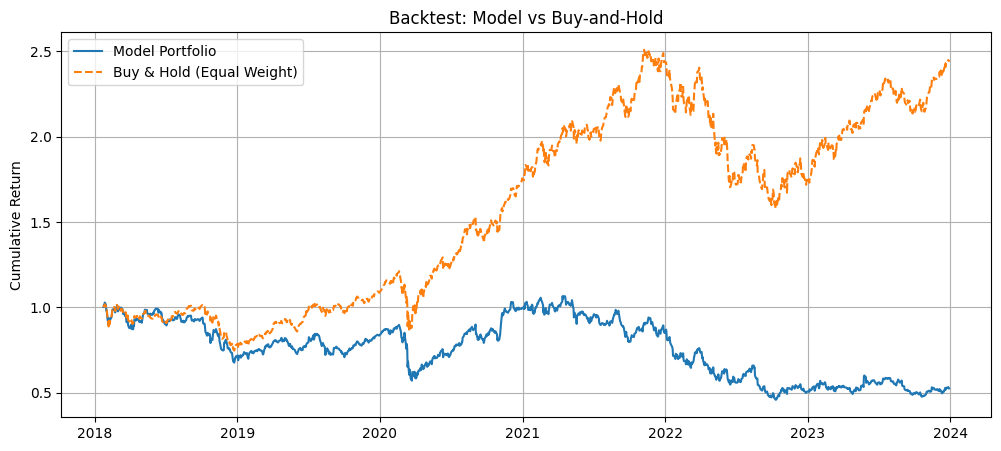

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Normalize prediction into daily weights
weights = pred_df.div(pred_df.sum(axis=1), axis=0).fillna(0)

# Model portfolio log returns
portfolio_log_returns = (weights * returns_df).sum(axis=1)
model_cumulative = np.exp(portfolio_log_returns.cumsum())

# Equal-weight buy-and-hold
equal_weight = 1 / len(tickers)
buy_hold_log_returns = returns_df.mean(axis=1)
buy_hold_cumulative = np.exp(buy_hold_log_returns.cumsum())

# Plot
plt.figure(figsize=(12, 5))
plt.plot(model_cumulative, label="Model Portfolio")
plt.plot(buy_hold_cumulative, label="Buy & Hold (Equal Weight)", linestyle="--")
plt.title("Backtest: Model vs Buy-and-Hold")
plt.ylabel("Cumulative Return")
plt.grid()
plt.legend()
plt.show()

In [4]:
from src.modeling_utils import generate_prediction_files

tickers = ["AAPL", "NVDA", "VOO", "JPM", "GLD", "BTC-USD", "PFE"]
generate_prediction_files(tickers)

🔍 Processing AAPL...
✅ Saved to data/predictions/AAPL_predictions.csv
🔍 Processing NVDA...
✅ Saved to data/predictions/NVDA_predictions.csv
🔍 Processing VOO...
✅ Saved to data/predictions/VOO_predictions.csv
🔍 Processing JPM...
✅ Saved to data/predictions/JPM_predictions.csv
🔍 Processing GLD...


/Users/tan/miniconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:08:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/tan/miniconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:08:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/tan/miniconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:08:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/tan/miniconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:08:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bs

✅ Saved to data/predictions/GLD_predictions.csv
🔍 Processing BTC-USD...
✅ Saved to data/predictions/BTC-USD_predictions.csv
🔍 Processing PFE...
✅ Saved to data/predictions/PFE_predictions.csv


/Users/tan/miniconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:08:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/tan/miniconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:08:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
